# Pre-processing and cleaning approved drugs (ChEMBL Web Resource)

In this step, we drop some missing and irrelevant stuff and reorder stuff. The objective of this notebook is to do the pre-cleaning and cleaning of the dataset gathered from ChEMBL Web Resource. More info about it below.

The ChEMBL Web Resource, as defined by the authors and mantainers in [GitHub](https://github.com/chembl/chembl_webresource_client): *'The library helps accessing ChEMBL data and cheminformatics tools from Python. You don't need to know how to write SQL. You don't need to know how to interact with REST APIs. You don't need to compile or install any cheminformatics frameworks. Results are cached.'*

## Importing packages and data

This section is dedicated to **import the packages and libraries** that we're going to use in this notebook, aswell as **the data** retrieved from *ChEMBL Web Resource* (more info above).

In [5]:
# Importing libraries
from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat
import pandas as pd
import re



In [6]:
# Importing the dataset:
approved_drugs_df = pd.read_csv('data/RAW_approved_drugs.csv')

## Step 1 - Pre-process

Taking a peek into the data we can see that there are a lot of variables that we don't need aswell as some rows depicting "NaN". We need to filter the bulk of information then refine it. This is the objective of the pre-process step.

In [7]:
# List of variables
print(approved_drugs_df.columns, "\n\n",approved_drugs_df.shape )
# Taking a peek into the data
approved_drugs_df.head(5)

Index(['atc_classifications', 'availability_type', 'biotherapeutic',
       'black_box_warning', 'chebi_par_id', 'chirality', 'cross_references',
       'dosed_ingredient', 'first_approval', 'first_in_class', 'helm_notation',
       'indication_class', 'inorganic_flag', 'max_phase', 'molecule_chembl_id',
       'molecule_hierarchy', 'molecule_properties', 'molecule_structures',
       'molecule_synonyms', 'molecule_type', 'natural_product', 'oral',
       'parenteral', 'polymer_flag', 'pref_name', 'prodrug', 'structure_type',
       'therapeutic_flag', 'topical', 'usan_stem', 'usan_stem_definition',
       'usan_substem', 'usan_year', 'withdrawn_class', 'withdrawn_country',
       'withdrawn_flag', 'withdrawn_reason', 'withdrawn_year', 'SMILES'],
      dtype='object') 

 (4121, 39)


,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,...,usan_stem,usan_stem_definition,usan_substem,usan_year,withdrawn_class,withdrawn_country,withdrawn_flag,withdrawn_reason,withdrawn_year,SMILES
0,['V03AN03'],1,NaN,0,30217.0,2,[],True,2015.0,0,...,-ium,quaternary ammonium derivatives,-ium,NaN,NaN,NaN,False,NaN,NaN,[He]
1,[],1,NaN,0,16134.0,2,"[{'xref_id': 'ammonia%20n-13', 'xref_name': 'a...",False,2007.0,0,...,NaN,NaN,NaN,1990.0,NaN,NaN,False,NaN,NaN,N
2,[],1,NaN,0,NaN,2,"[{'xref_id': 'ammonia%20n-13', 'xref_name': 'a...",True,2007.0,0,...,NaN,NaN,NaN,1990.0,NaN,NaN,False,NaN,NaN,[13NH3]
3,[],2,NaN,0,15377.0,2,"[{'xref_id': 'purified%20water', 'xref_name': ...",True,2011.0,0,...,deu-,deuterated compounds,deu-,1963.0,NaN,NaN,False,NaN,NaN,O
4,['V03AN04'],1,NaN,0,17997.0,2,[],True,2015.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,N#N


In [8]:
# Verifying the 'not found' SMILES
print("Number of not found SMILES, before filtering: ", approved_drugs_df.query("SMILES == 'not found'").shape[0])

Number of not found SMILES, before filtering:  674


We can filter the information of only those variables:
* pref_name
* SMILES
* molecule_chembl_id
* first_approval
* molecule_type
* indication_class
* polymer_flag
* withdrawn_flag
* withdrawn_year
* inorganic_flag
* therapeutic_flag
* natural_product
* oral
* parenteral
* topical

In [9]:
approved_drugs_df = approved_drugs_df[[
    'pref_name',
    'SMILES',
    'molecule_chembl_id',
    'first_approval',
    'molecule_type',
    'indication_class',
    'polymer_flag',
    'withdrawn_flag',
    'inorganic_flag',
    'therapeutic_flag',
    'withdrawn_year',
    'natural_product',
    'oral', 
    'parenteral', 
    'topical',
]].copy()

Next we do the following pre-cleaning steps:
* Filter only the *Small molecules* on the `molecule_type` variable;
* Remove strictly *inorganic* and *polymers*;
* Remove radioactive, gases and diluent;
* Only `therapeutic_flag` == True

In [11]:
# Filtering the structures:
# We want only 'Small molecule', don't want inorganic or polymer stuff
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['molecule_type'] == 'Small molecule']
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['inorganic_flag'] == 0]
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['polymer_flag'] == 0]

# We don't want indication_class containing the word "gases" or "diluent" or "radioactive"
approved_drugs_df = approved_drugs_df[~approved_drugs_df['indication_class'].str.contains("radioactive|gases|diluent|disinfectant|flavor|preservative|diagnostic|excipient|plutonium|aid", flags=re.IGNORECASE, regex=True, na=False)]

# with terapeutic_flag == True
approved_drugs_df = approved_drugs_df[approved_drugs_df['therapeutic_flag'] == True]

In [13]:
approved_drugs_df

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,withdrawn_year,natural_product,oral,parenteral,topical
5,NITRIC OXIDE,[N]=O,CHEMBL1200689,1999.0,Small molecule,NaN,0,False,0,True,NaN,0,False,False,True
9,HYDROGEN PEROXIDE,OO,CHEMBL71595,2017.0,Small molecule,"Anti-Infective, Topical",0,False,0,True,NaN,0,False,False,True
14,NITROUS OXIDE,N#[N+][O-],CHEMBL1234579,NaN,Small molecule,Anesthetic (inhalation),0,False,0,True,NaN,0,False,False,False
23,GUANIDINE,N=C(N)N,CHEMBL821,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False
24,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,"SYNTHETIC CONJUGATED ESTROGENS, B",not found,CHEMBL1201467,2004.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False
3954,CRYPTENAMINE TANNATES,not found,CHEMBL1201603,1982.0,Small molecule,NaN,0,False,0,True,NaN,1,True,False,False
3995,"ESTROGENS, ESTERIFIED",not found,CHEMBL1201468,1977.0,Small molecule,Estrogen,0,False,0,True,NaN,1,True,False,False
3999,ALKAVERVIR,not found,CHEMBL1201658,1982.0,Small molecule,NaN,0,False,0,True,NaN,1,True,False,False


## Separating for manual curation

Saving another `.csv` for manual curation of `SMILES` == 'not found' and `first_approval` == 'NaN':

In [15]:
manual_curation_df = approved_drugs_df[(approved_drugs_df['SMILES'] == 'not found') | (approved_drugs_df['first_approval'].isna())]

# Taking a peek
manual_curation_df.head(5)

In [21]:
manual_curation_df.to_csv('data/RAW_manual_curation_dataset.csv', index=False)
print(f"Size of the manual curation dataset: {manual_curation_df.shape[0]}")

534

In [20]:
# Droppping from the main dataset the SMILES not found and first_approval
approved_drugs_df = approved_drugs_df[~(approved_drugs_df['SMILES'] == 'not found') & ~   (approved_drugs_df['first_approval'].isna())].copy()

# The main dataset has now:
print(f"Size of the {approved_drugs_df.shape[0]}")

2380

## Calculating mw to use as filter

2380


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,withdrawn_year,natural_product,oral,parenteral,topical,ROMol
5,NITRIC OXIDE,[N]=O,CHEMBL1200689,1999.0,Small molecule,NaN,0,False,0,True,NaN,0,False,False,True,
9,HYDROGEN PEROXIDE,OO,CHEMBL71595,2017.0,Small molecule,"Anti-Infective, Topical",0,False,0,True,NaN,0,False,False,True,
23,GUANIDINE,N=C(N)N,CHEMBL821,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False,
24,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False,
36,LITHIUM CARBONATE,O=C([O-])[O-].[Li+].[Li+],CHEMBL1200826,1970.0,Small molecule,Antimanic,0,False,0,True,NaN,0,True,False,False,

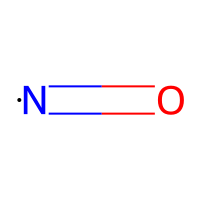
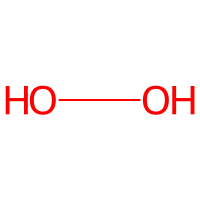
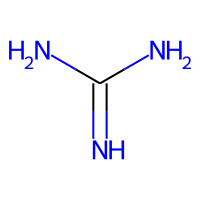
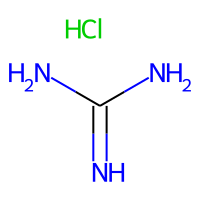
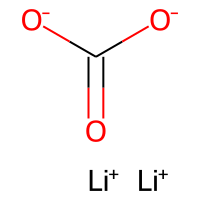

In [22]:
PandasTools.AddMoleculeColumnToFrame(approved_drugs_df, smilesCol='SMILES')
print(approved_drugs_df.shape[0])
approved_drugs_df.head(5)

In [ ]:
approved_drugs_df

Now we can do some tweaking into our dataframe:
* **Rounding** the number of approval date (just for aesthetic)
* **Reordering** the dataframe into a more logic variable sequence

In [94]:
#Rounding the datetime
approved_drugs_df['first_approval'] = approved_drugs_df['first_approval'].apply(int)

# Reordering the dataframe
approved_drugs_df = approved_drugs_df[['pref_name','SMILES','first_approval','polymer_flag','indication_class','withdrawn_flag','inorganic_flag','polymer_flag','therapeutic_flag','natural_product','oral', 'parenteral', 'topical']]

print("\n", approved_drugs_df.columns, "\n")
print(f"The dataset has the shape {approved_drugs_df.shape}")
approved_drugs_df


 Index(['pref_name', 'SMILES', 'first_approval', 'polymer_flag',
       'indication_class', 'withdrawn_flag', 'inorganic_flag', 'polymer_flag',
       'therapeutic_flag', 'natural_product', 'oral', 'parenteral', 'topical'],
      dtype='object') 

The dataset has the shape (2396, 13)


,pref_name,SMILES,first_approval,polymer_flag,indication_class,withdrawn_flag,inorganic_flag,polymer_flag,therapeutic_flag,natural_product,oral,parenteral,topical
0,NITRIC OXIDE,[N]=O,1999,0,NaN,False,0,0,True,0,False,False,True
1,HYDROGEN PEROXIDE,OO,2017,0,"Anti-Infective, Topical",False,0,0,True,0,False,False,True
2,GUANIDINE,N=C(N)N,1939,0,NaN,False,0,0,True,0,True,False,False
3,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,1939,0,NaN,False,0,0,True,0,True,False,False
4,LITHIUM CARBONATE,O=C([O-])[O-].[Li+].[Li+],1970,0,Antimanic,False,0,0,True,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,TELAVANCIN,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,0,NaN,False,0,0,True,1,False,True,False
2392,TELAVANCIN HYDROCHLORIDE,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,0,NaN,False,0,0,True,1,False,True,False
2393,ERGOLOID,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,1953,0,Cognition Adjuvant,False,0,0,True,1,True,False,True
2394,ERGOLOID MESYLATES,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,1953,0,Cognition Adjuvant,False,0,0,True,1,True,False,True


Now we're left with the following problems:
* Extremely small structures such as Nitric Oxide, Hydrogen Peroxide that cannot be used to derive any rules. (Maybe this can be solved by applying some MW filter)
* Repeated SMILES (salt and conjugated) - Maybe this can be solved by keeping the largest fragment and dropping x*plicated SMILES.
* Extremely large structures such as OMEGA-3-Carboxylic Acids (Apply some MW filter? Maybe)

Solving the first problem (extremely small structures). We calculate the mol_format 